In [1]:
import os
import cv2
import copy
from open3d import *
import numpy as np
import numpy.ma as ma
from matplotlib import pyplot as plt

In [2]:
img_depth = read_image('cup/depth-100.png')
np.histogram(img_depth)

(array([566319, 319744,  28839,     11,     12,   2632,   3259,    590,
           184,     10]),
 array([    0. ,  1329.2,  2658.4,  3987.6,  5316.8,  6646. ,  7975.2,
         9304.4, 10633.6, 11962.8, 13292. ]))

### Композиции на фреймах различаются:

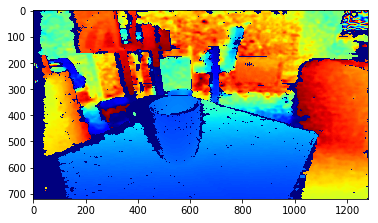

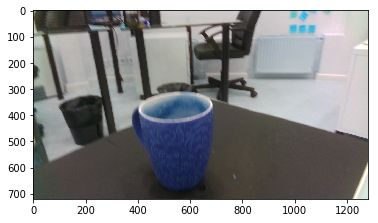

In [3]:
#brightness and contrast tuning for visual recognition
plt.imshow((np.asarray(read_image('cup/depth-100.png'))*45)+45, cmap='jet') 
plt.figure()
plt.imshow(cv2.imread('cup/rgb-100.png'))

## Отфильтруем картинку сначала по глубине, а затем по черному цвету, чтобы на карте глубины осталась только чашка

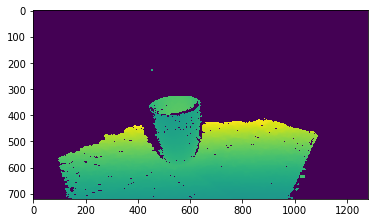

In [4]:
# We are cropping all foreground except cup and table
img_filtered = np.asarray(img_depth).copy()
img_filtered[img_filtered>500] = 0
np.histogram(img_filtered)
plt.imshow(img_filtered)

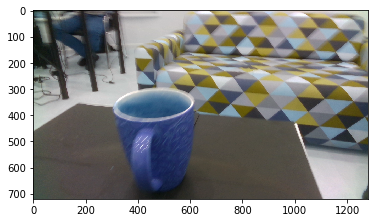

In [5]:
img = cv2.imread('cup/rgb-200.png')
plt.imshow(img) 

In [6]:
# Masking by depth. We need it to remove background
img_filtered = np.expand_dims(img_filtered,2)
img_filtered = np.concatenate([img_filtered, img_filtered, img_filtered], axis=2)

masked_array_depth = ma.masked_where( img_filtered==0 , img)
masked_array_depth.set_fill_value(100)
masked_origin_depth = masked_array_depth.filled()

In [7]:
# Masking by black color. We need it to remove table
lower_black = np.array([0,0,0], dtype = "uint16")
upper_black = np.array([570,570,80], dtype = "uint16")
black_mask = cv2.inRange(img, lower_black, upper_black)

black_mask = np.expand_dims(black_mask,2)
black_mask = np.concatenate([black_mask, black_mask, black_mask], axis=2)

masked_array_black = ma.masked_where(black_mask!=0 , img)
masked_array_black.set_fill_value(0)
masked_origin_black = masked_array_black.filled()

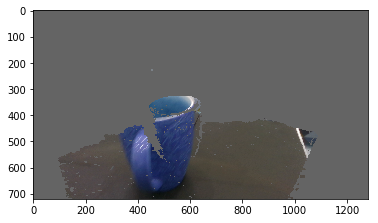

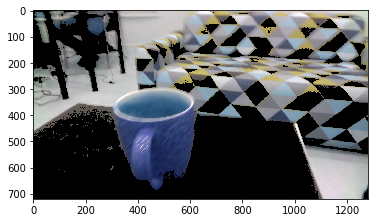

In [8]:
plt.imshow(masked_origin_depth)
plt.figure()
plt.imshow(masked_origin_black)

### Картинка отфильрована по двум параметрам (глубина и черные элементы), но, так как depth и png данные расходятся, то при объединении этих масок мы не получим искомый объект на depth карте и не восстановим его правильно.
### Если бы сходились, то можно объединить маски, наложить на depth, дальше при помощи opencv пройтись поверх этого комбинашкой erosion/dilation, так же, возможно, пришлось бы найти большие объекты и удалить все маленькие

### В результате, на depth карте, получили бы довольно полную чашку без всех фонов и объединив в 3d можно генерить меш.

### Ниже идут наброски алгоритмов, которые я пробовал для того чтобы все же объединить кадры, которые помогли придти к пониманию что с данными что-то не так:

#### Пробуем вывести 3д сцену одной картики:

Read SUN dataset
RGBDImage of size 
Color image : 1280x720, with 1 channels.
Depth image : 1280x720, with 1 channels.
Use numpy.asarray to access buffer data.


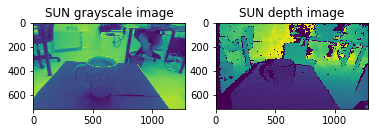

In [9]:
print("Read SUN dataset")
color_raw = read_image("cup/rgb-133.png")
depth_raw = read_image("cup/depth-133.png")
rgbd_image = create_rgbd_image_from_color_and_depth(color_raw, depth_raw);
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('SUN grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('SUN depth image')
plt.imshow(rgbd_image.depth)
plt.show()
pcd = create_point_cloud_from_rgbd_image(rgbd_image, PinholeCameraIntrinsic(
    PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
draw_geometries([pcd])


### Так как на не нужна вся сцена, задний фон будет мешать при попытке любых объединений, можем откинуть по глубине задний фон у всех depth, оставив чашку и столик:

In [10]:
mkdir ./cup_cropped

mkdir: ./cup_cropped: File exists


In [11]:
for file in os.listdir('./cup'):
    if 'depth' in file:
        img_depth = read_image('./cup/%s' % file)
        img_filtered = np.asarray(img_depth).copy()
        img_filtered[img_filtered>500] = 0
        write_image('./cup_cropped/%s' % file, Image(img_filtered))
print('Depth images were cropped')

Depths images were cropped


### Пробуем вывести новый скропленный объект чашко-стол

In [12]:
color_raw = read_image("cup/rgb-133.png")
depth_raw = read_image("cup_cropped/depth-133.png")
rgbd_image = create_rgbd_image_from_color_and_depth(color_raw, depth_raw);
pcd = create_point_cloud_from_rgbd_image(rgbd_image, PinholeCameraIntrinsic(
            PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
draw_geometries([pcd])

###  Попробуем восстановить 3д этого `чашкостола`. Сначала тестим алгоритмы ICP Point-to-Point и Colored ICP на 2х картинках. Рендерим 3д сцену из объединения.

In [13]:

def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    draw_geometries([source_temp, target])

color_raw = read_image("cup/rgb-133.png")
depth_raw = read_image("cup_cropped/depth-133.png")
source = create_rgbd_image_from_color_and_depth(color_raw, depth_raw)
source = create_point_cloud_from_rgbd_image(source, PinholeCameraIntrinsic(
            PinholeCameraIntrinsicParameters.PrimeSenseDefault))

color_raw = read_image("cup/rgb-134.png")
depth_raw = read_image("cup_cropped/depth-134.png")
target = create_rgbd_image_from_color_and_depth(color_raw, depth_raw)
target = create_point_cloud_from_rgbd_image(target, PinholeCameraIntrinsic(
            PinholeCameraIntrinsicParameters.PrimeSenseDefault))


# draw initial alignment
current_transformation = np.identity(4)
draw_registration_result_original_color(
        source, target, current_transformation)

# point to plane ICP
current_transformation = np.identity(4);
print("2. Point-to-plane ICP registration is applied on original point")
print("   clouds to refine the alignment. Distance threshold 0.02.")
result_icp = registration_icp(source, target, 0.02,
        current_transformation, TransformationEstimationPointToPoint())
print(result_icp)
draw_registration_result_original_color(
        source, target, result_icp.transformation)

# colored pointcloud registration
# This is implementation of following paper
# J. Park, Q.-Y. Zhou, V. Koltun,
# Colored Point Cloud Registration Revisited, ICCV 2017
voxel_radius = [ 0.04, 0.02, 0.01 ];
max_iter = [ 50, 30, 14 ];
current_transformation = np.identity(4)
print("3. Colored point cloud registration")
for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter,radius,scale])

    print("3-1. Downsample with a voxel size %.2f" % radius)
    source_down = voxel_down_sample(source, radius)
    target_down = voxel_down_sample(target, radius)

    print("3-2. Estimate normal.")
    estimate_normals(source_down, KDTreeSearchParamHybrid(
            radius = radius * 2, max_nn = 30))
    estimate_normals(target_down, KDTreeSearchParamHybrid(
            radius = radius * 2, max_nn = 30))

    print("3-3. Applying colored point cloud registration")
    result_icp = registration_colored_icp(source_down, target_down,
            radius, current_transformation,
            ICPConvergenceCriteria(relative_fitness = 1e-6,
            relative_rmse = 1e-6, max_iteration = iter))
    current_transformation = result_icp.transformation
    print(result_icp)
draw_registration_result_original_color(
        source, target, result_icp.transformation)

2. Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. Distance threshold 0.02.
RegistrationResult with fitness = 0.999728, inlier_rmse = 0.001413, and correspondence_set size of 242142
Access transformation to get result.
3. Colored point cloud registration
[50, 0.04, 0]
3-1. Downsample with a voxel size 0.04
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness = 0.987654, inlier_rmse = 0.011799, and correspondence_set size of 160
Access transformation to get result.
[30, 0.02, 1]
3-1. Downsample with a voxel size 0.02
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness = 0.998168, inlier_rmse = 0.005116, and correspondence_set size of 545
Access transformation to get result.
[14, 0.01, 2]
3-1. Downsample with a voxel size 0.01
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness = 0.995498, inlier_

### Дальше идет алгоритм, который бегает по всем скропленным файлам глубины и пытается в цикле кадр за кадром восстановить полноценный объект чашко-стола. Цикл ограничен [:5] 5-ю итерациями, для теста.

In [ ]:
list_of_depth_files = os.listdir('./cup_cropped/')
list_of_depth_files.sort(key=lambda x: int(x.replace('depth-','').replace('.png','')))
i = 0
target = None
source_down, target_down = None, None
list_transformed = []

def read_pointcloud_from_images(filename):
    print("Concat file: ", filename)
    color_raw = read_image("./cup/%s" % filename.replace('depth', 'rgb'))
    depth_raw = read_image("./cup_cropped/%s" % filename)
    f = create_rgbd_image_from_color_and_depth(color_raw, depth_raw)
    return create_point_cloud_from_rgbd_image(f, PinholeCameraIntrinsic(
                PinholeCameraIntrinsicParameters.PrimeSenseDefault))

while i < len(list_of_depth_files[:5])-1:
    if not target:
        target = read_pointcloud_from_images(list_of_depth_files[i])
        list_transformed.append(target)
    else:
        target = source
    source = read_pointcloud_from_images(list_of_depth_files[i+1])

#     current_transformation = np.identity(4);
    
#     print("3. Colored point cloud registration")
    voxel_radius = [ 0.04, 0.02, 0.01 ];
    max_iter = [ 50, 30, 14 ];
    current_transformation = np.identity(4)
    print("3. Colored point cloud registration")
    for scale in range(3):
        iter = max_iter[scale]
        radius = voxel_radius[scale]
        print([iter,radius,scale])

        print("3-1. Downsample with a voxel size %.2f" % radius)
        source_down = voxel_down_sample(source, radius)
        target_down = voxel_down_sample(target, radius)

        print("3-2. Estimate normal.")
        estimate_normals(source_down, KDTreeSearchParamHybrid(
                radius = radius * 2, max_nn = 30))
        estimate_normals(target_down, KDTreeSearchParamHybrid(
                radius = radius * 2, max_nn = 30))

        print("3-3. Applying colored point cloud registration")
        result_icp = registration_colored_icp(source_down, target_down,
                radius, current_transformation,
                ICPConvergenceCriteria(relative_fitness = 1e-6,
                relative_rmse = 1e-6, max_iteration = iter))
        current_transformation = result_icp.transformation
        print(result_icp)
        source_temp = copy.deepcopy(source)
        source_temp.transform(result_icp.transformation)
        list_transformed.append(source_temp)
    i += 1

print("Transformed images: ", len(list_transformed))
draw_geometries(list_transformed)

### На выходе можно получить понитклауд чашко-стола, а если брать depth только чашки, то чашку, которую можно превратить в меш при помощи marching cubes, например